In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [39]:
def hill_activation(x, K, n, ymin, ymax):
    
    return ymin + (ymax - ymin) * (x**n / (K**n + x**n))

def hill_activation_simple(x, K, n):
    
    return (x**n / (K**n + x**n))

def read_datasets(folder):
    
    names = ['fluos', 'ods', 'fluos-lower-1', 'fluos-lower-2']
    datasets = []
    for name in names:
        datasets.append(pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, name), index_col='time'))
    return datasets

In [3]:
promoters = ['pBAD/Ara', 'pCin/OHC14', 'pCymRC/Cuma', 'pLuxB/AHL', 'pPhlF/DAPG', 'pSalTTC/Sal', 'pRhaB/Rha']
ecfs = ['e11x33', 'e15x33', 'e16x33','e20x33', 'e32x33', 'e34x33', 'e38x33', 'e41x33', 'e42x33']
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB', 'e34x30MjaKlbA',
         'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']

#### Cherrypicking 3 Promoters Characterization - 24 induction levels

In [89]:
folder = '011-3-promoters-detailed-characterization'
fluos, ods, fluos_1, fluos_2 = read_datasets(folder)

In [41]:
promoters = ['pBAD/Ara', 'pCymRC/Cuma', 'pRhaB/Rha']
aras = [0, 4.95911E-05, 9.91821E-05, 0.000198364, 0.000396729, 0.000793457, 0.001586914, 0.003173828, 0.006347656, 0.012695313, 0.025390625, 0.05078125, 0, 0.1015625, 0.203125, 0.40625, 0.8125, 1.625, 3.25, 6.5, 13, 26, 52, 104]
cumas = [0, 0.001525879, 0.003051758, 0.006103516, 0.012207031, 0.024414063, 0.048828125, 0.09765625, 0.1953125, 0.390625, 0.78125, 1.5625, 0, 3.125, 6.25, 12.5, 25, 50, 100, 200, 400, 800, 1600, 3200]
rhas = [0, 0.014591217, 0.029182434, 0.058364868, 0.116729736, 0.233459473, 0.466918945, 0.933837891, 1.867675781, 3.735351563, 7.470703125, 14.94140625, 0, 29.8828125, 59.765625, 119.53125, 239.0625, 478.125, 956.25, 1912.5, 3825, 7650, 15300, 30600]
inducers = [aras, cumas, rhas]

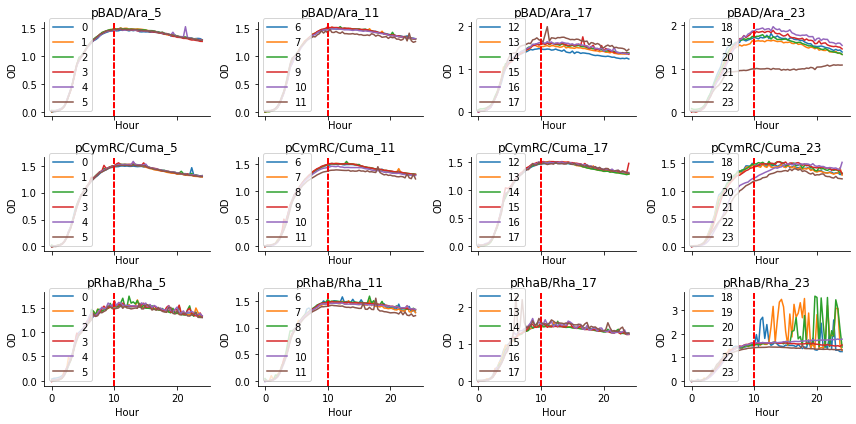

In [75]:
f, axs = plt.subplots(3, 4, sharex=True, sharey=False, figsize=(12, 6))
for i in range(3):
    for j in range(0, 6):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 0].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 0].axvline(10, color='red', linestyle='--')
        axs[i, 0].legend()
        axs[i, 0].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 0].set_ylabel('OD')
        axs[i, 0].set_xlabel('Hour')
    for j in range(6, 12):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 1].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 1].axvline(10, color='red', linestyle='--')
        axs[i, 1].legend()
        axs[i, 1].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 1].set_ylabel('OD')
        axs[i, 1].set_xlabel('Hour')
    for j in range(12, 18):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 2].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 2].axvline(10, color='red', linestyle='--')
        axs[i, 2].legend()
        axs[i, 2].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 2].set_ylabel('OD')
        axs[i, 2].set_xlabel('Hour')
    for j in range(18, 24):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 3].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 3].axvline(10, color='red', linestyle='--')
        axs[i, 3].legend()
        axs[i, 3].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 3].set_ylabel('OD')
        axs[i, 3].set_xlabel('Hour')
sns.despine()
plt.tight_layout()

In [108]:
def get_control(fluos, h):

    idx = 3 * h
    gfp = fluos[filter(lambda x: x.startswith('positive-control-amp'), fluos.columns)].mean(axis=1)
    neg_amp = fluos[filter(lambda x: x.startswith('negative-control-amp'), fluos.columns)].mean(axis=1)
    neg_kan = fluos[filter(lambda x: x.startswith('negative-control-kan'), fluos.columns)].mean(axis=1)
    neg_kan_10, gfp_10, neg_amp_10 = neg_kan.iloc[idx], gfp.iloc[idx], neg_amp.iloc[idx]
    return neg_kan_10, gfp_10, neg_amp_10

def promoters_plots(row, col, data, inducers, promoters, ctrl, h, sharex=True, sharey=False):
    
    idx = 3 * h
    responses = []
    f, axs = plt.subplots(row, col, sharex=sharex, sharey=sharey, figsize=(col*5, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(promoters):
            response = []
            for j in range(12):
                #if j < 12:
                #    if j%2==1:
                #        continue
                #else:
                #    if j%2==0:
                #        continue
                d = data['{}_{}'.format(promoters[i], j)]
                rpu = (d.iloc[idx] - ctrl[0]) / (ctrl[1] - ctrl[2])
                ax.scatter(inducers[i][j], rpu, label=np.round(inducers[i][j], 5))
                ax.loglog()
                #ax.set_xscale('symlog')
                #ax.set_yscale('symlog')
                #print(promoters[i], j, inducers[i][j])
                response.append(rpu)
            ax.set_title('{}_{}'.format(promoters[i], j))
            #ax.set_xticks(np.arange(12))
            #ax.set_xticklabels([np.round(u, 2) for u in inducers[i]], rotation=45)
            #ax.legend()
            responses.append(response)
        else:
            ax.set_visible(False)
    sns.despine()
    plt.tight_layout()
    return responses

In [111]:
aras_cp = [(4.95911e-05/4), 4.95911e-05, 0.000198364, 0.000793457, 0.003173828, 0.012695313, 0.05078125, 0.203125, 0.8125, 3.25, 13, 52]
rhas_cp = [(0.014591217/4), 0.014591217, 0.058364868, 0.233459473, 0.933837891, 3.735351563, 14.94140625, 59.765625, 239.0625, 956.25, 3825, 15300]
inducers_cp = [aras_cp, rhas_cp]
promoters_cp = ['pBAD/Ara', 'pRhaB/Rha']

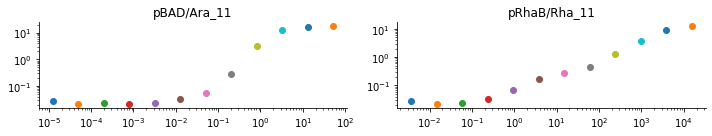

In [112]:
responses = promoters_plots(1, 2, fluos_2, inducers_cp, promoters_cp, get_control(fluos_2, 10), 10, sharex=False)

<ipython-input-86-e8fbefd71660>:29: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.loglog()
<ipython-input-86-e8fbefd71660>:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(inducers[i][j], rpu, label=np.round(inducers[i][j], 5))


pBAD/Ara 0 0
pBAD/Ara 2 9.91821e-05
pBAD/Ara 4 0.000396729
pBAD/Ara 6 0.001586914
pBAD/Ara 8 0.006347656
pBAD/Ara 10 0.025390625
pBAD/Ara 13 0.1015625
pBAD/Ara 15 0.40625
pBAD/Ara 17 1.625
pBAD/Ara 19 6.5
pBAD/Ara 21 26
pBAD/Ara 23 104
pCymRC/Cuma 0 0
pCymRC/Cuma 2 0.003051758
pCymRC/Cuma 4 0.012207031
pCymRC/Cuma 6 0.048828125
pCymRC/Cuma 8 0.1953125
pCymRC/Cuma 10 0.78125
pCymRC/Cuma 13 3.125
pCymRC/Cuma 15 12.5
pCymRC/Cuma 17 50
pCymRC/Cuma 19 200
pCymRC/Cuma 21 800
pCymRC/Cuma 23 3200
pRhaB/Rha 0 0
pRhaB/Rha 2 0.029182434
pRhaB/Rha 4 0.116729736
pRhaB/Rha 6 0.466918945
pRhaB/Rha 8 1.867675781
pRhaB/Rha 10 7.470703125
pRhaB/Rha 13 29.8828125
pRhaB/Rha 15 119.53125
pRhaB/Rha 17 478.125
pRhaB/Rha 19 1912.5
pRhaB/Rha 21 7650
pRhaB/Rha 23 30600


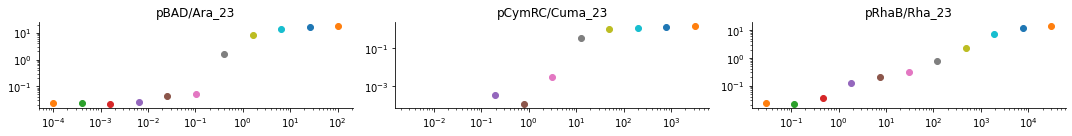

In [87]:
responses = promoters_plots(1, 3, fluos_2, inducers, promoters, get_control(fluos_2, 10), 10, sharex=False)

#### Promoters Characterization - 6 induction levels

In [ ]:
folder = '004-promoters-characterization'
fluos, ods, fluos_1, fluos_2 = read_datasets(folder)
fluos_ods = fluos_2 / ods

In [ ]:
aras = [0, 0.8125, 3.25, 13, 52, 208]
ohcs = [0, 0.039, 0.156, 0.625, 2.5, 10]
cumas = [0, 6.25, 12.5, 25, 50, 100]
ahls = [0, 0.039, 0.156, 0.625, 2.5, 10]
dapgs = [0, 0.098, 0.391, 1.563, 6.25, 25]
sals = [0, 0.391, 1.563, 6.25, 25, 100]
rhas = [0, 59.766, 239.063, 956.25, 3825, 15300]
inducers = [aras, ohcs, cumas, ahls, dapgs, sals, rhas]

In [ ]:
idx = 3 * 10
gfp = fluos_2[filter(lambda x: x.startswith('positive-control-amp'), fluos_ods.columns)].mean(axis=1)
neg = fluos_2[filter(lambda x: x.startswith('negative-control-kan'), fluos_ods.columns)].mean(axis=1)
gfp10, neg10 = gfp.iloc[idx], neg.iloc[idx]
gfp10, neg10

In [ ]:
f, axs = plt.subplots(7, 2, sharex=True, sharey=False, figsize=(6, 10))
for i in range(7):
    for j in range(3):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 0].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 0].axvline(10, color='red', linestyle='--')
        axs[i, 0].legend()
        axs[i, 0].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 0].set_ylabel('OD')
        axs[i, 0].set_xlabel('Hour')
    for j in range(3, 6):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 1].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 1].axvline(10, color='red', linestyle='--')
        axs[i, 1].legend()
        axs[i, 1].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 1].set_ylabel('OD')
        axs[i, 1].set_xlabel('Hour')
sns.despine()
plt.tight_layout()

In [ ]:
def promoters_plots(row, col, data, promoters, sharex=True, sharey=False):
    
    #xs = np.arange(12)
    responses = []
    f, axs = plt.subplots(row, col, sharex=sharex, sharey=sharey, figsize=(col*3, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(promoters):
            response = []
            for j in range(6):
                d = data['{}_{}'.format(promoters[i], j)]
                rpu = (d.iloc[idx] - neg.iloc[idx]) / (gfp.iloc[idx] - neg.iloc[idx])
                ax.scatter(np.log(inducers[i][j]), np.log(rpu))
                response.append(rpu)
            ax.set_title('{}_{}'.format(promoters[i], j))
            #ax.set_xticks(np.arange(12))
            #ax.set_xticklabels([np.round(u, 2) for u in inducers[i]], rotation=45)
            responses.append(response)
        else:
            ax.set_visible(False)
    sns.despine()
    plt.tight_layout()
    
    return responses

responses = promoters_plots(2, 4, fluos_2, promoters, sharex=False, sharey=False)

#### Promoters Characterization - 12 induction levels

In [132]:
def get_control(fluos, h):

    idx = 3 * h
    gfp = fluos[filter(lambda x: x.startswith('positive-control-amp'), fluos.columns)].mean(axis=1)
    neg_amp = fluos[filter(lambda x: x.startswith('negative-control-amp'), fluos.columns)].mean(axis=1)
    neg_kan = fluos[filter(lambda x: x.startswith('negative-control-kan'), fluos.columns)].mean(axis=1)
    neg_kan_10, gfp_10, neg_amp_10 = neg_kan.iloc[idx], gfp.iloc[idx], neg_amp.iloc[idx]
    return neg_kan_10, gfp_10, neg_amp_10

def promoters_plots(row, col, data, inducers, promoters, ctrl, h, sharex=True, sharey=False):
    
    idx = 3 * h
    responses = []
    f, axs = plt.subplots(row, col, sharex=sharex, sharey=sharey, figsize=(col*3, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(promoters):
            response = []
            for j in range(12):
                d = data['{}_{}'.format(promoters[i], j)]
                rpu = (d.iloc[idx] - ctrl[0]) / (ctrl[1] - ctrl[2])
                ax.scatter(inducers[i][j], rpu, label=np.round(inducers[i][j], 2))
                ax.loglog()
                #ax.set_xscale('symlog')
                #ax.set_yscale('symlog')
                response.append(rpu)
            ax.set_title('{}_{}'.format(promoters[i], j))
            #ax.set_xticks(np.arange(12))
            #ax.set_xticklabels([np.round(u, 2) for u in inducers[i]], rotation=45)
            #ax.legend(bbox_to_anchor=(1.1, 1.1))
            responses.append(response)
        else:
            ax.set_visible(False)
    sns.despine()
    plt.tight_layout()
    return responses

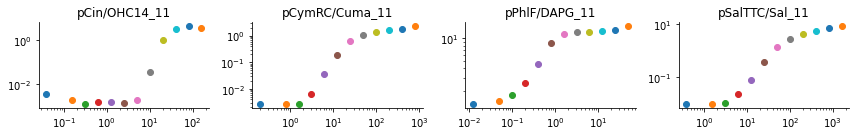

In [152]:
#006
folder = '006-promoters-characterization'
fluos, ods, fluos_1, fluos_2 = read_datasets(folder)
aras = [(0.40625/4), 0.40625, 0.8125, 1.625, 3.25, 6.5, 13, 26, 52, 104, 208, 416]
ohcs = [(0.15625/4), 0.15625, 0.3125, 0.625, 1.25, 2.5, 5, 10, 20, 40, 80, 160]
cumas = [(0.78125/4), 0.78125, 1.5625, 3.125, 6.25, 12.5, 25, 50, 100, 200, 400, 800]
ahls = [(0.01953125/4), 0.01953125, 0.0390625, 0.078125, 0.15625, 0.3125, 0.625, 1.25, 2.5, 5, 10, 20]
dapgs = [(0.048828125/4), 0.048828125, 0.09765625, 0.1953125, 0.390625, 0.78125, 1.5625, 3.125, 6.25, 12.5, 25, 50]
sals = [(1.5625/4), 1.5625, 3.125, 6.25, 12.5, 25, 50, 100, 200, 400, 800, 1600]
rhas = [(14.94140625/4), 14.94140625, 29.8828125, 59.765625, 119.53125, 239.0625, 478.125, 956.25, 1912.5, 3825, 7650, 15300]
inducers = [ohcs, cumas, dapgs, sals]
promoters = ['pCin/OHC14', 'pCymRC/Cuma', 'pPhlF/DAPG', 'pSalTTC/Sal']
responses = promoters_plots(1, 4, fluos_2, inducers, promoters, get_control(fluos_2, 10), 10, sharex=False)

In [153]:
df_res1 = pd.DataFrame(responses).T
df_res1.columns = promoters
df_ind1 = pd.DataFrame(inducers).T
df_ind1.columns = promoters

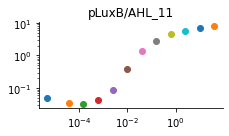

In [154]:
#010 - AHL & Rha
folder = '010-promoters-characterization'
fluos, ods, fluos_1, fluos_2 = read_datasets(folder)
aras = [(0.406/8), 0.406, 0.609, 0.813, 1.219, 1.625, 2.438, 3.25, 6.5, 13, 26, 104]
ohcs = [(8/4), 8, 10, 16, 20, 32, 40, 64, 80, 128, 160, 320]
cumas = [(3.125/4), 3.125, 6.25, 12.5, 25, 50, 100, 200, 400, 800, 1600, 3200]
ahls = [(3.81e-5/8), 3.81e-5, 1.53e-4, 6.1e-4, 2.44e-3, 9.77e-3, 3.91e-2, 0.156, 0.625, 2.5, 10, 40]
dapgs = [(0.048828125/4), 0.048828125, 0.09765625, 0.1953125, 0.390625, 0.78125, 1.5625, 3.125, 6.25, 12.5, 25, 50] #does not matter
sals = [(25/4), 25, 50, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
rhas = [(29.88/4), 29.88, 59.76, 119.53, 239.06, 478.125, 956.25, 1912.5, 3825, 7650, 15300, 30600]
inducers = [ahls]
promoters = [ 'pLuxB/AHL']
responses = promoters_plots(1, 2, fluos_2, inducers, promoters, get_control(fluos_2, 10), 10, sharex=False)

In [155]:
df_res2 = pd.DataFrame(responses).T
df_res2.columns = promoters
df_ind2 = pd.DataFrame(inducers).T
df_ind2.columns = promoters

In [156]:
df_res = pd.concat([df_res1, df_res2], axis=1)
df_ind = pd.concat([df_ind1, df_ind2], axis=1)

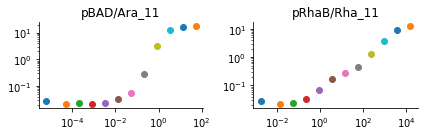

In [157]:
#011
folder = '011-3-promoters-detailed-characterization'
fluos, ods, fluos_1, fluos_2 = read_datasets(folder)
aras_cp = [(4.95911e-05/8), 4.95911e-05, 0.000198364, 0.000793457, 0.003173828, 0.012695313, 0.05078125, 0.203125, 0.8125, 3.25, 13, 52]
rhas_cp = [(0.014591217/8), 0.014591217, 0.058364868, 0.233459473, 0.933837891, 3.735351563, 14.94140625, 59.765625, 239.0625, 956.25, 3825, 15300]
inducers = [aras_cp, rhas_cp]
promoters = ['pBAD/Ara', 'pRhaB/Rha']

responses = promoters_plots(1, 2, fluos_2, inducers, promoters, get_control(fluos_2, 10), 10, sharex=False)

In [158]:
df_res3 = pd.DataFrame(responses).T
df_res3.columns = promoters
df_ind3 = pd.DataFrame(inducers).T
df_ind3.columns = promoters

In [159]:
df_res = pd.concat([df_res, df_res3], axis=1)
df_ind = pd.concat([df_ind, df_ind3], axis=1)

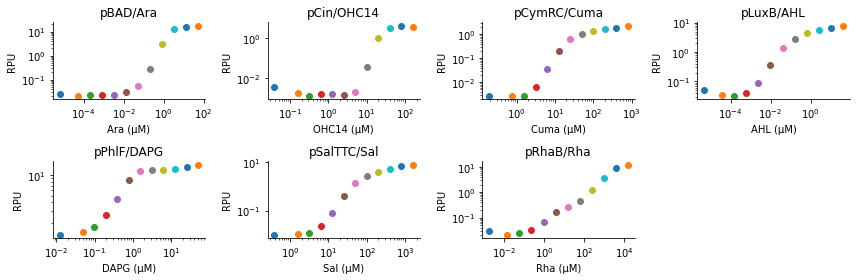

In [162]:
def promoters_combined_plots(row, col, data, inducers):
    
    cols = ['pBAD/Ara', 'pCin/OHC14', 'pCymRC/Cuma', 'pLuxB/AHL', 'pPhlF/DAPG', 'pSalTTC/Sal', 'pRhaB/Rha']
    #ind_names = ['OHC14', 'Cuma', 'DAPG', 'Sal', 'AHL', 'Ara', 'Rha']
    #cols = data.columns.tolist()
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*3, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(cols):
            for x, y in zip(inducers[cols[i]], data[cols[i]]):
                ax.scatter(x, y)
                ax.loglog()
            ax.set_title('{}'.format(cols[i]))
            ax.set_ylabel('RPU')
            ax.set_xlabel('{} ({})'.format(cols[i].split('/')[1], u"\u03bcM"))
        else:
            ax.set_visible(False)
    sns.despine()
    plt.tight_layout()
                         
promoters_combined_plots(2, 4, df_res, df_ind)

In [164]:
df_res.to_csv('datasets/experiment/responses.csv', index=False)
df_ind.to_csv('datasets/experiment/inducers.csv', index=False)

#### Response Function

In [97]:
promoters = ['pBAD/Ara', 'pCin/OHC14', 'pCymRC/Cuma', 'pLuxB/AHL', 'pPhlF/DAPG', 'pSalTTC/Sal', 'pRhaB/Rha']
responses = pd.read_csv('datasets/experiment/responses.csv')
inducers = pd.read_csv('datasets/experiment/inducers.csv')

In [65]:
for i in range(responses.shape[1]):
    responses.iloc[:,i] = (responses.iloc[:,i] - responses.iloc[:,i].min())
responses

,pCin/OHC14,pCymRC/Cuma,pPhlF/DAPG,pSalTTC/Sal,pLuxB/AHL,pBAD/Ara,pRhaB/Rha
0,0.446362,0.000000,0.000000,0.000000,0.199450,0.099102,0.126181
1,0.164810,0.000000,0.039458,0.022064,0.020414,0.000000,0.000000
2,0.000000,0.000000,0.114408,0.045616,0.000000,0.032446,0.043263
3,0.099131,0.390368,0.283958,0.361051,0.111375,0.021433,0.180101
4,0.116506,1.135663,0.529241,0.906437,0.436296,0.056249,0.498390
5,0.062148,1.865375,0.805065,1.577656,1.068272,0.181670,0.894929
6,0.179787,2.380412,0.931277,2.118867,1.627851,0.420904,1.094944
7,1.443564,2.598791,0.951524,2.429458,1.938191,1.115855,1.326932
8,2.891909,2.716426,0.956915,2.596619,2.147822,2.172773,1.772367
9,3.382262,2.777838,0.970324,2.725558,2.255088,2.796423,2.229951


pBAD/Ara [ 8.37369304 10.         -1.64724754  1.41978148] 0.9966771991919787
pCin/OHC14 [ 8.34790734 10.         -2.8169881   0.86877922] 0.9791152547492948
pCymRC/Cuma [ 5.38577075  5.86240147 -2.60379805  0.31000544] 0.9992182586228897
pLuxB/AHL [ 6.294877    6.70536224 -1.43852298  0.87935695] 0.9965898557198248
pPhlF/DAPG [4.8367284  5.62609016 0.15213736 1.13495076] 0.9967691727066526
pSalTTC/Sal [ 5.83041091  5.08293872 -2.00665582  0.93703335] 0.9995312330302457
pRhaB/Rha [ 9.1058868   3.59234269 -1.61945191  2.09645081] 0.9914391316413436


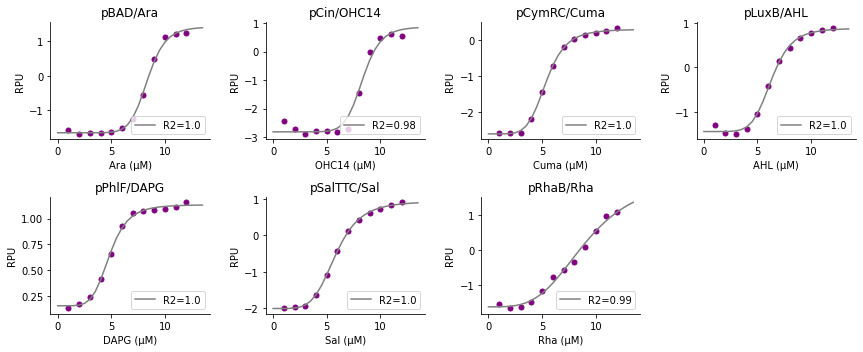

In [92]:
all_params = []
f, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(12, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(promoters):
        y = responses[promoters[i]]
        x = np.arange(1, len(y)+1)
        #x = inducers[promoters[i]]
        init_guess = [1, 1, y.min(), y.max()]
        gate_bounds = [[0, 0, y.min()-1, y.max()-1],
                       [1e4, 10, y.min()+1, y.max()+1]]
        
        popt, pcov = curve_fit(hill_activation, x, y, p0=init_guess, bounds=gate_bounds)
        
        ax.scatter(x, y, color='purple', s=25)
        err = np.round(r2_score(y, hill_activation(x, *popt)), 2)
        #err = np.sum([(a - b)**2 for a, b in zip(y, hill_activation(x, *popt))])
        ax.plot(np.arange(0, x.max()+2, 0.5), hill_activation(np.arange(0, x.max()+2, 0.5), *popt), color='gray', label='R2=' + str(err))
        
        all_params.append(popt)
        print(promoters[i], popt, r2_score(y, hill_activation(x, *popt)))
        #ax.loglog()
        #ax.set_xscale('symlog')
        #ax.set_yscale('symlog')
        #ax.set_xticks(np.arange(len(inducers[promoters[i]])))
        #ax.set_xticklabels(None)
        
        ax.set_title('{}'.format(promoters[i]))
        ax.set_ylabel('RPU')
        ax.set_xlabel('{} ({})'.format(promoters[i].split('/')[1], u"\u03bcM"))
        ax.legend(loc=4)
    else:
        ax.set_visible(False)
    sns.despine()
plt.tight_layout()

pBAD/Ara [ 1.7417835   1.92103684  0.01866273 16.84860927] 0.9987538102042821
pCin/OHC14 [2.68564446e+01 3.76767115e+00 1.36584521e-12 3.90107448e+00] 0.9925106233686215
pCymRC/Cuma [6.43660297e+01 1.12236469e+00 3.57502369e-27 2.20881602e+00] 0.9847186764939855
pLuxB/AHL [4.37582246e-01 6.61066607e-01 2.91445832e-14 7.92527956e+00] 0.9974209904138268
pPhlF/DAPG [ 0.62842382  1.80866346  1.30224474 13.02780023] 0.9894806260820344
pSalTTC/Sal [2.04624968e+02 1.21563670e+00 1.84740630e-17 8.21842410e+00] 0.994145452557632
pRhaB/Rha [1.79586797e+03 1.38299906e+00 1.21523179e-01 1.25867902e+01] 0.9969512608896169


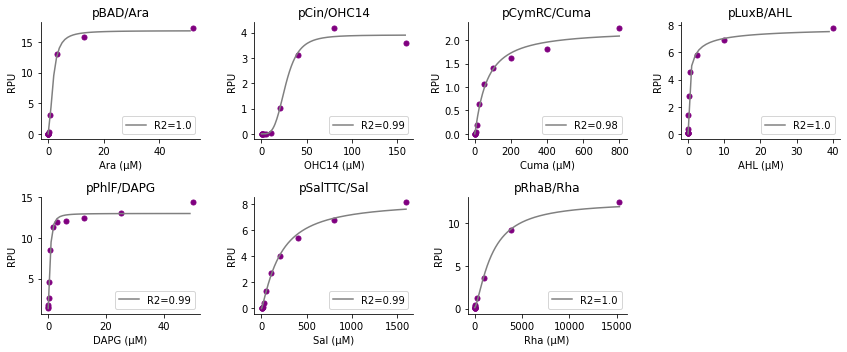

In [95]:
all_params = []
f, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(12, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(promoters):
        y = responses[promoters[i]]
        x = inducers[promoters[i]]
        init_guess = [1, 1, y.min(), y.max()]
        gate_bounds = [[0, 0, 0, 0],
                       [1e4, 4, y.min()+0.1, y.max()+0.1]]
        
        popt, pcov = curve_fit(hill_activation, x, y, p0=init_guess, bounds=gate_bounds)
        
        ax.scatter(x, y, color='purple', s=25)
        err = np.round(r2_score(y, hill_activation(x, *popt)), 2)
        #err = np.sum([(a - b)**2 for a, b in zip(y, hill_activation(x, *popt))])
        ax.plot(np.arange(x.max()), hill_activation(np.arange(x.max()), *popt), color='gray', label='R2='+str(err))
        
        all_params.append(popt)
        print(promoters[i], popt, r2_score(y, hill_activation(x, *popt)))
        #ax.loglog()
        #ax.set_xscale('symlog')
        #ax.set_yscale('symlog')
        
        ax.set_title('{}'.format(promoters[i]))
        ax.set_ylabel('RPU')
        ax.set_xlabel('{} ({})'.format(promoters[i].split('/')[1], u"\u03bcM"))
        ax.legend(loc=4)
    else:
        ax.set_visible(False)
    sns.despine()
plt.tight_layout()

In [98]:
inducers

,pCin/OHC14,pCymRC/Cuma,pPhlF/DAPG,pSalTTC/Sal,pLuxB/AHL,pBAD/Ara,pRhaB/Rha
0,0.00000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000
1,0.15625,0.78125,0.048828,1.5625,0.000038,0.000050,0.014591
2,0.31250,1.56250,0.097656,3.1250,0.000153,0.000198,0.058365
3,0.62500,3.12500,0.195312,6.2500,0.000610,0.000793,0.233459
4,1.25000,6.25000,0.390625,12.5000,0.002440,0.003174,0.933838
5,2.50000,12.50000,0.781250,25.0000,0.009770,0.012695,3.735352
6,5.00000,25.00000,1.562500,50.0000,0.039100,0.050781,14.941406
7,10.00000,50.00000,3.125000,100.0000,0.156000,0.203125,59.765625
8,20.00000,100.00000,6.250000,200.0000,0.625000,0.812500,239.062500
9,40.00000,200.00000,12.500000,400.0000,2.500000,3.250000,956.250000


In [107]:
for j, c in enumerate(promoters):
    print('"', c.split('/')[1].lower(), '_rpu":', [hill_activation(i, *all_params[j]) for i in inducers[c]])

" ara _rpu": [0.01866272721909743, 0.018662758406971503, 0.018663174328483034, 0.018669139227864114, 0.018754681366803718, 0.01998134569699118, 0.037553287271685845, 0.2855753748649402, 3.1780033414207476, 12.94761562060246, 16.501814359447273, 16.823954609817722]
" ohc14 _rpu": [1.365845205649679e-12, 1.477809602543448e-08, 2.0126270200342847e-07, 2.7412100433656457e-06, 3.733535555988354e-05, 0.0005084518764194502, 0.0069138207147784935, 0.09210718741881846, 0.9665193941238823, 3.1899661887779125, 3.8382539899376513, 3.8963923018006925]
" cuma _rpu": [3.575023694350424e-27, 0.015516608586247045, 0.03350318091899451, 0.07165827267981141, 0.15026467493653695, 0.302879007101705, 0.5677451197898489, 0.9489157692128366, 1.3720392703934798, 1.7254466182928356, 1.9569898978633842, 2.085543568949304]
" ahl _rpu": [2.9144583244448006e-14, 0.016371822448534235, 0.040914484578614636, 0.10129783845740496, 0.24851484541441368, 0.5938269471580947, 1.3351050307360446, 2.6617291185039744, 4.42741186

In [23]:
cumas_gate = [0, 6.25, 12.5, 25, 50, 100]
aras_gate = [0, 0.8125, 3.25, 13, 52, 208]
cumas_rpu = [hill_activation(i, *all_params[2]) for i in cumas_gate]
aras_rpu = [hill_activation(i, *all_params[0]) for i in aras_gate]
print(cumas_rpu)
print(aras_rpu)

[5.160308727625551e-22, 0.1503530957891216, 0.30298032564481925, 0.5678111055145855, 0.9488899036690079, 1.371938809116961]
[0.018662727197652017, 3.178003346532333, 12.947615590104748, 16.501814366047896, 16.823954625777105, 16.846887772258317]


Data Inspections

In [ ]:
f, axs = plt.subplots(7, 2, sharex=False, sharey=False, figsize=(6, 10))
for i in range(7):
    for j in range(5, 6):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 0].plot(r0.index/60, r0)#, color='darkblue')
        axs[i, 0].axvline(10, color='red', linestyle='--', label='10h')
        #axs[i, 1].legend()
        axs[i, 0].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 0].set_ylabel('OD')
        axs[i, 0].set_xlabel('Hour')
    for j in range(6, 12):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 1].plot(r0.index/60, r0)#, color='darkblue')
        axs[i, 1].axvline(10, color='red', linestyle='--', label='10h')
        #axs[i, 1].legend()
        axs[i, 1].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 1].set_ylabel('OD')
        axs[i, 1].set_xlabel('Hour')
sns.despine()
plt.tight_layout()

In [ ]:
f, axs = plt.subplots(7, 12, sharex=True, sharey=True, figsize=(20, 10))
for i in range(7):
    for j in range(12):
        r0 = fluos_2['{}_{}'.format(promoters[i], j)]
        axs[i, j].plot(r0.index/60, r0, color='darkblue')
        axs[i, j].axvline(10, color='red', linestyle='--', label='10h')
        axs[i, j].legend()
        axs[i, j].set_title('{}_{}'.format(promoters[i], j))
        axs[i, j].set_ylabel('Fluo (a.u.)')
        axs[i, j].set_xlabel('Hour')
sns.despine()
plt.tight_layout()